In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import datetime as dt

from Package.PlotHandler import *

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 설정
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
raw_data_df = pd.read_excel('Data/데이터 취합(240528).xlsx')

In [4]:
tidy_data = raw_data_df.dropna()
tidy_data.set_index('date', inplace=True)

In [5]:
# KOSPI 가격 수준 지표
kospi_rolling_window = 125

kospi_index_df = tidy_data[['코스피 지수']].copy()
kospi_index_df['코스피 125MA'] = kospi_index_df.rolling(window=125).mean()
kospi_index_df['kospi_deviation'] = kospi_index_df['코스피 지수'] - kospi_index_df['코스피 125MA']

In [6]:
# 신고저가 종목 Net 52 high_low(구성종목수 추가)
krx_highlow_window = 125

krx_52highlow_df = tidy_data[['KRX 신고가 종목', 'KRX 신저가 종목', '코스피 거래종목 수 ', '코스닥 거래종목 수']].copy()
krx_52highlow_5days_df = krx_52highlow_df.rolling(window=50).sum()
krx_52highlow_5days_df['net_high_low_ratio'] = (
    (krx_52highlow_5days_df.iloc[:,0] - krx_52highlow_5days_df.iloc[:,1])/
        (krx_52highlow_5days_df.iloc[:,2]+krx_52highlow_5days_df.iloc[:,3])
    )

In [7]:
# Put, Call ratio 5일 계산
put_call_ratio_window = 5
put_call_ratio_df = tidy_data[['거래량 Put', '거래량 Call']].copy()
put_call_ratio_df['put/call ratio'] = put_call_ratio_df['거래량 Put']/ put_call_ratio_df['거래량 Call']
put_call_5d_sum = put_call_ratio_df.rolling(window=put_call_ratio_window).mean()

In [8]:
# VKOSPI 50일 이동 평균 Deviation
vkospi_window = 50
vkospi_df = tidy_data[['VKOSPI']].copy()
vkospi_df['50ma'] = vkospi_df.rolling(window=vkospi_window).mean()
vkospi_df['vkospi_deviance'] = vkospi_df['VKOSPI'] - vkospi_df['50ma']

In [9]:
# 회사채 Spread(Junk bond Spread)
junk_bond_spread_df = tidy_data[['국고채권(3년)','회사채(무보증3년)AA-', '회사채(무보증3년)BBB-']].copy()
junk_bond_spread_df['junkbond_spread'] = -junk_bond_spread_df['회사채(무보증3년)AA-']  +junk_bond_spread_df['회사채(무보증3년)BBB-']
junk_bond_spread_df['credit_spread'] = -junk_bond_spread_df['국고채권(3년)']  +junk_bond_spread_df['회사채(무보증3년)AA-']

In [10]:
# 채권, 주식 수익률(1개월, 3개월,6개월, 12개월 각각 계산 등, CNN에서는 20일 수익률 사용)
safe_haven_window = 20
safe_haven_demand_df = tidy_data[['코스피 지수', '국고채권(10년)']].copy()
safe_haven_demand_df['코스피 20일 수익률'] = safe_haven_demand_df['코스피 지수'].pct_change(periods=safe_haven_window)
safe_haven_demand_df['채권 20일 수익률'] = np.nan
for i in range(20, len(safe_haven_demand_df)):
    r_t_1 = safe_haven_demand_df.iloc[i- safe_haven_window + 1,1]
    r_t = safe_haven_demand_df.iloc[i,1]
    bond_return = r_t_1/r_t + r_t_1/1200 + ((1+r_t/1200)**(-119) * (1- r_t_1/r_t))
    safe_haven_demand_df.iloc[i, 3] = bond_return-1
safe_haven_demand_df['safe_haven_return'] = safe_haven_demand_df['코스피 20일 수익률'] - safe_haven_demand_df['채권 20일 수익률']


In [11]:
# 상승, 하락 종목수 Sentiment
mcclellan_df = tidy_data[['코스피 상승종목수', '코스피 하락종목수']].copy()
mcclellan_df['net advance'] = mcclellan_df['코스피 상승종목수'] - mcclellan_df['코스피 하락종목수']
mcclellan_df['ratio_adjusted'] = mcclellan_df['net advance']/(mcclellan_df['코스피 상승종목수'] + mcclellan_df['코스피 하락종목수'])*1000

# 19일 EMA 계산
mcclellan_df['19_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=50, adjust=False).mean()

# 39일 EMA 계산
mcclellan_df['39_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=125, adjust=False).mean()

# 19일 EMA와 39일 EMA의 차이 계산
mcclellan_df['EMA_diff'] = mcclellan_df['19_day_EMA'] - mcclellan_df['39_day_EMA']

In [12]:
data_name_list = ['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread', 'credit_spread', 'safe_haven_return', 'EMA_diff',
                  'USD/KRW', 'KR_CDS_spread']
whole_data_df = pd.DataFrame([
        put_call_5d_sum['put/call ratio'],
        kospi_index_df['kospi_deviation'],
        vkospi_df['vkospi_deviance'],
        junk_bond_spread_df['junkbond_spread'],
        junk_bond_spread_df['credit_spread'],
        safe_haven_demand_df['safe_haven_return'],
        mcclellan_df['EMA_diff'],
        tidy_data['원/달러(종가)'],
        tidy_data['한국 CDS Spread'],
    ], index = data_name_list)

whole_data_df = whole_data_df.T

In [13]:
#### PCA 결과

def rolling_standardize(series, window):
    """주어진 시리즈에 대해 윈도우 크기를 사용하여 표준화합니다."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    standardized_series = (series - rolling_mean) / rolling_std
    return standardized_series

# 각 열에 대한 윈도우 크기를 정의합니다
window_sizes = {
    'PC_ratio': 504,
    'KOSPI_dev': 125,
    'VKOSPI_dev': 50,
    'junkbond_spread': 50,
    'credit_spread': 50,
    'safe_haven_return': 50,
    'EMA_diff': 504,
    'USD/KRW': 50,
    'KR_CDS_spread': 50
}

minus_sign = {
    'PC_ratio': True,
    'KOSPI_dev': False,
    'VKOSPI_dev': True,
    'junkbond_spread': True,
    'credit_spread': True,
    'safe_haven_return': False,
    'EMA_diff': False,
    'USD/KRW': True,
    'KR_CDS_spread': True
}

# 각 열에 대해 표준화를 수행합니다
standardized_df = pd.DataFrame(index=whole_data_df.index)

for column, window in window_sizes.items():
    if minus_sign[column]:
        standardized_df[column] = rolling_standardize(-whole_data_df[column], window)
    else:
        standardized_df[column] = rolling_standardize(whole_data_df[column], window)

mean_values = standardized_df.T.mean().T * 50 + 50

def normalize_series(series, window=125):
    rolling_min = series.rolling(window=window, min_periods=1).min()
    rolling_max = series.rolling(window=window, min_periods=1).max()
    normalized_series = (series - rolling_min) / (rolling_max - rolling_min)
    return normalized_series

# 그냥 지수
normalized_mean_values = mean_values
# 100으로 변환 되도록 바꿈
normalized_mean_values = normalize_series(mean_values) *100

<Axes: >

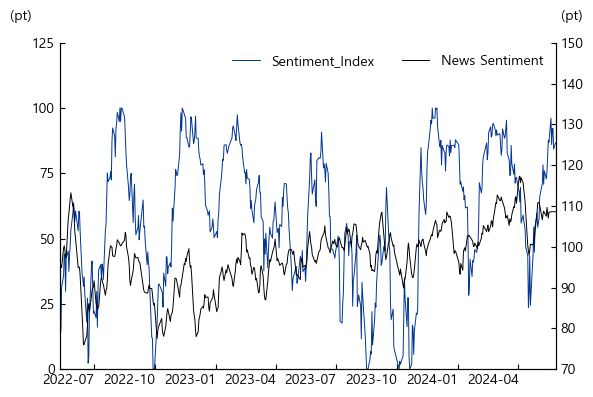

In [14]:
last_plot_n = 504
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

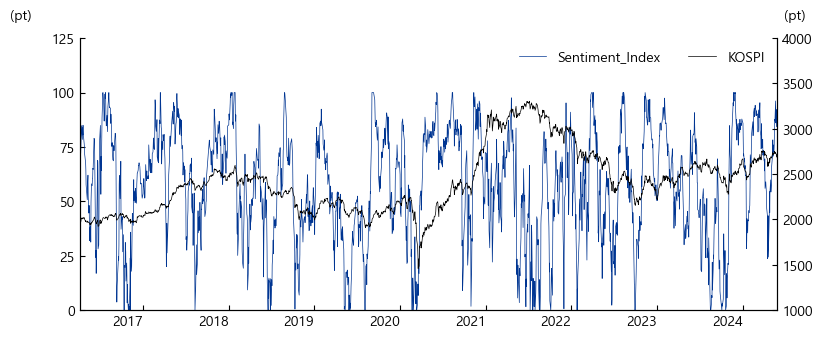

In [15]:
last_plot_n = 2000
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index', 'KOSPI']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.5)

<Axes: >

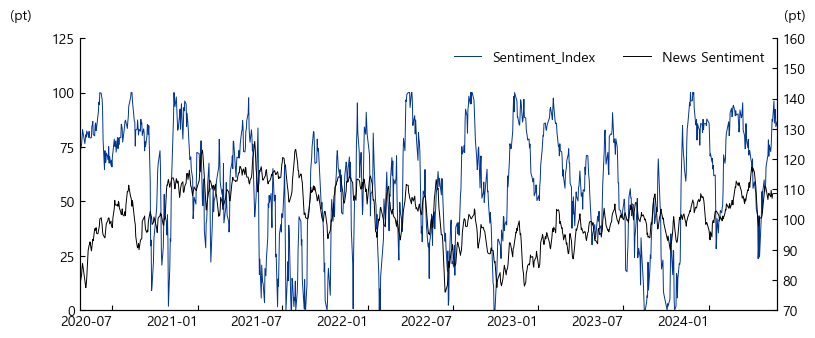

In [16]:
last_plot_n = 1008
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

[-0.02253051  0.43574972  0.29090684 -0.12903808  0.28268422  0.3596675
  0.30567102  0.44008241  0.46038958]


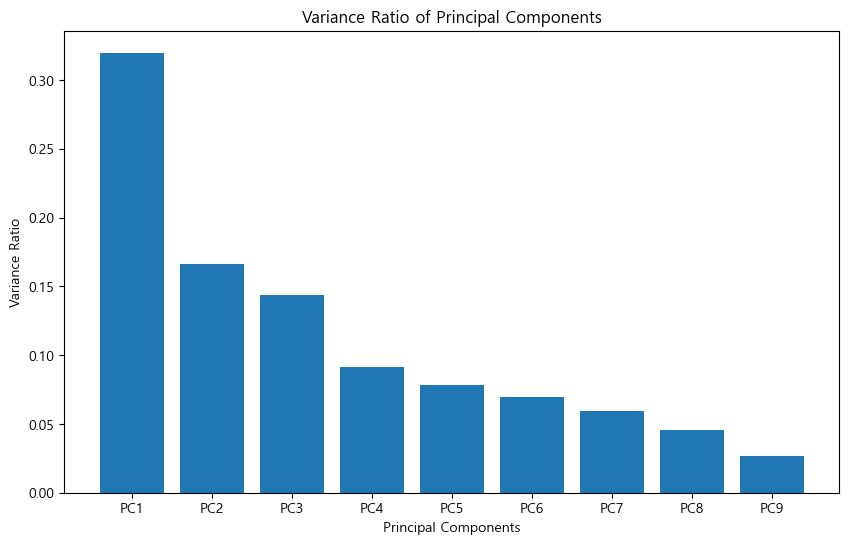

In [17]:
# 전체 기간
pca_feature_df = standardized_df.dropna()
n_principal_component = 9
from sklearn.decomposition import PCA
pca = PCA(n_components=n_principal_component) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(pca_feature_df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                                                'PC6', 'PC7', 'PC8', 'PC9'])
principal_vectors = - pca.components_
print(principal_vectors[0])
# 고유값과 고유값 비율 계산
eigenvalues = pca.explained_variance_
eigenvalue_ratios = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_principal_component + 1), eigenvalue_ratios, tick_label=[f'PC{i}' for i in range(1, n_principal_component + 1)])
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio of Principal Components')
plt.show()

In [18]:
# 전체 기간
pca_feature_df = standardized_df.dropna()
n_th_pc = 1
n_principal_component = 9
from sklearn.decomposition import PCA
pca = PCA(n_components=n_principal_component) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(pca_feature_df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                                                'PC6', 'PC7', 'PC8', 'PC9'])

principalDf = -principalDf.iloc[:, n_th_pc-1]
principalDf.index = pca_feature_df.index
principal_vectors = - pca.components_


print(principal_vectors[0, :])
print(standardized_df.columns)

[-0.02253051  0.43574972  0.29090684 -0.12903808  0.28268422  0.3596675
  0.30567102  0.44008241  0.46038958]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


<Axes: >

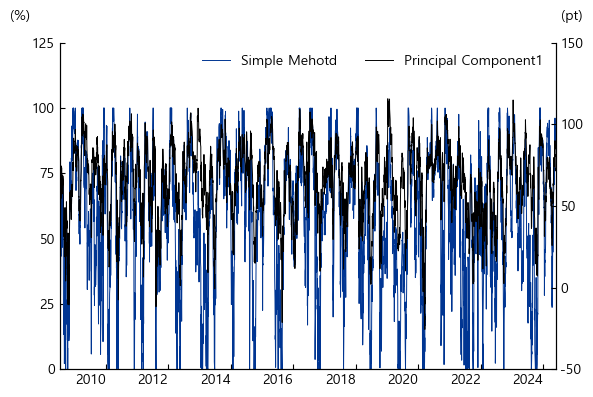

In [19]:
principalDf.index = pca_feature_df.index
# print(pd.DataFrame(mean_values).head())
# print(principalDf.head())
plot_df = pd.merge(pd.DataFrame(normalized_mean_values),principalDf * 10 + 65, left_index=True, right_index=True)
plot_df.columns = ['Simple Mehotd', 'Principal Component1']
plot_multi(data=plot_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

## 1개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [20]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = -22
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     252.5
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           5.50e-55
Time:                        14:54:07   Log-Likelihood:                -9287.2
No. Observations:                3551   AIC:                         1.858e+04
Df Residuals:                    3549   BIC:                         1.859e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1069      0.697    -14.510      0.0

## 1개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [21]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.594
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0321
Time:                        14:54:07   Log-Likelihood:                -10583.
No. Observations:                3528   AIC:                         2.117e+04
Df Residuals:                    3526   BIC:                         2.118e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1483      0.882      2.435      0.0

## 3개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [22]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = -60
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     92.76
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           1.09e-21
Time:                        14:54:07   Log-Likelihood:                -11745.
No. Observations:                3551   AIC:                         2.349e+04
Df Residuals:                    3549   BIC:                         2.351e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.7108      1.169     -7.454      0.0

## 3개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [23]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.6087
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.435
Time:                        14:54:08   Log-Likelihood:                -11968.
No. Observations:                3490   AIC:                         2.394e+04
Df Residuals:                    3488   BIC:                         2.395e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3199      1.645      1.411      0.1

## 6개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [24]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = -125
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     19.92
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           8.35e-06
Time:                        14:54:08   Log-Likelihood:                -13368.
No. Observations:                3551   AIC:                         2.674e+04
Df Residuals:                    3549   BIC:                         2.675e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.1351      2.299     -3.104      0.0

## 6개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [25]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                    0.4296
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.512
Time:                        14:54:08   Log-Likelihood:                -13086.
No. Observations:                3425   AIC:                         2.618e+04
Df Residuals:                    3423   BIC:                         2.619e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3165      3.545      1.218      0.2

## 12개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [50]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.366
Date:                Sun, 09 Jun 2024   Prob (F-statistic):            0.00385
Time:                        14:57:30   Log-Likelihood:                -15200.
No. Observations:                3551   AIC:                         3.040e+04
Df Residuals:                    3549   BIC:                         3.042e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7581      4.521     -0.389      0.6

## 12개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [48]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.638
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.201
Time:                        14:57:17   Log-Likelihood:                -2335.0
No. Observations:                 586   AIC:                             4674.
Df Residuals:                     584   BIC:                             4683.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.2550      8.346     -1.468      0.1

# 21년 이후

## 1개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [47]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = -22
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     99.42
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.36e-22
Time:                        14:57:12   Log-Likelihood:                -2218.3
No. Observations:                 837   AIC:                             4441.
Df Residuals:                     835   BIC:                             4450.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.4861      1.003    -10.457      0.0

## 1개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [46]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.555
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0331
Time:                        14:57:08   Log-Likelihood:                -2377.0
No. Observations:                 814   AIC:                             4758.
Df Residuals:                     812   BIC:                             4767.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6074      1.591      1.639      0.1

## 3개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [45]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = -60
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     26.87
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.73e-07
Time:                        14:57:04   Log-Likelihood:                -2898.0
No. Observations:                 837   AIC:                             5800.
Df Residuals:                     835   BIC:                             5809.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2040      2.116     -4.349      0.0

## 3개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [44]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                    0.5222
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.470
Time:                        14:57:00   Log-Likelihood:                -2479.9
No. Observations:                 776   AIC:                             4964.
Df Residuals:                     774   BIC:                             4973.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2585      2.370     -0.953      0.3

## 6개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [43]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = -125
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     8.553
Date:                Sun, 09 Jun 2024   Prob (F-statistic):            0.00354
Time:                        14:56:56   Log-Likelihood:                -3381.3
No. Observations:                 837   AIC:                             6767.
Df Residuals:                     835   BIC:                             6776.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.1046      5.262     -2.680      0.0

## 6개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [41]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                   0.06195
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.803
Time:                        14:56:28   Log-Likelihood:                -4983.7
No. Observations:                1205   AIC:                             9971.
Df Residuals:                    1203   BIC:                             9982.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2769      8.100      0.158      0.8

## 12개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [42]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.075
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.150
Time:                        14:56:37   Log-Likelihood:                -6094.9
No. Observations:                1331   AIC:                         1.219e+04
Df Residuals:                    1329   BIC:                         1.220e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3056      9.313     -0.462      0.6

## 12개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [35]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.638
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.201
Time:                        14:55:19   Log-Likelihood:                -2335.0
No. Observations:                 586   AIC:                             4674.
Df Residuals:                     584   BIC:                             4683.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.2550      8.346     -1.468      0.1